# Smart Bus Stop Analyzer: Real-time Anomaly Detection and Passenger Flow Prediction
## COMPX523-25A Assignment 3 - Group 6

### Problem Statement
Public transportation systems face significant challenges in managing passenger flow, detecting service disruptions, and optimizing bus schedules. This project addresses these challenges by developing a **multi-stream online learning system** that:

1. **Detects anomalies** in passenger boarding/landing patterns in real-time
2. **Predicts short-term passenger flow** (next 30 minutes) for dynamic scheduling
3. **Identifies network-wide patterns** across multiple bus stops

### Innovation Highlights
- **Multi-stream processing**: Simultaneously analyzes boarding, landing, and loader data
- **Adaptive learning**: Uses CapyMOA's online algorithms to adapt to changing patterns
- **Practical impact**: Enables real-time decision making for bus operators

## 1. Auto-Reload Setup
Reload all modules automatically before executing any code to ensure the latest changes are used.

In [533]:
# Load autoreload extension
%load_ext autoreload

# Reload all modules automatically
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [534]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Import our smart bus analyzer
from smart_bus_analyzer import SmartBusStopAnalyzer, MultiStopNetworkAnalyzer

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 2. Data Loading and Exploration

In [535]:
# Load the datasets
boarding_df = pd.read_csv('https://huggingface.co/datasets/labiaufba/SSA_StopBusTimeSeries_5/resolve/main/boarding_03-05_2024.csv')
landing_df = pd.read_csv('https://huggingface.co/datasets/labiaufba/SSA_StopBusTimeSeries_5/resolve/main/landing_03-05_2024.csv')
loader_df = pd.read_csv('https://huggingface.co/datasets/labiaufba/SSA_StopBusTimeSeries_5/resolve/main/loader_03-05_2024.csv')

print("Dataset shapes:")
print(f"Boarding: {boarding_df.shape}")
print(f"Landing: {landing_df.shape}")
print(f"Loader: {loader_df.shape}")

# Display first few rows
print("\nSample data (boarding):")
boarding_df.head()

Dataset shapes:
Boarding: (21840, 11)
Landing: (21840, 11)
Loader: (21840, 11)

Sample data (boarding):


,Unnamed: 0,125960550,230565994,258781031,43768720,44072192,44783654,44783914,44784438,45833547,47568123
0,2024-03-01 05:00:00,0,0,0,0,0,0,0,0,0,0
1,2024-03-01 05:05:00,0,0,0,0,0,0,0,0,0,0
2,2024-03-01 05:10:00,0,0,1,3,0,0,0,0,0,0
3,2024-03-01 05:15:00,0,0,1,3,0,0,0,0,0,0
4,2024-03-01 05:20:00,0,0,2,9,0,0,0,0,0,0


In [536]:
# First, let's examine the data structure
print("Columns in boarding_df:")
print(boarding_df.columns.tolist()[:10])  # Show all 10 columns
print(f"\nTotal columns: {len(boarding_df.columns)}")
print(f"Data shape: {boarding_df.shape}")

# Check if timestamp is in columns or index
timestamp_col = None
for col in boarding_df.columns:
    if 'time' in col.lower() or 'date' in col.lower():
        timestamp_col = col
        break

# Handle timestamp based on data structure
if timestamp_col:
    print(f"\nUsing column '{timestamp_col}' as timestamp")
    boarding_df['timestamp'] = pd.to_datetime(boarding_df[timestamp_col])
    landing_df['timestamp'] = pd.to_datetime(landing_df[timestamp_col])
    loader_df['timestamp'] = pd.to_datetime(loader_df[timestamp_col])
elif boarding_df.index.name and 'time' in str(boarding_df.index.name).lower():
    print("\nTimestamp found in index")
    boarding_df = boarding_df.reset_index()
    landing_df = landing_df.reset_index()
    loader_df = loader_df.reset_index()
    boarding_df['timestamp'] = pd.to_datetime(boarding_df.iloc[:, 0])
    landing_df['timestamp'] = pd.to_datetime(landing_df.iloc[:, 0])
    loader_df['timestamp'] = pd.to_datetime(loader_df.iloc[:, 0])
else:
    # Assume first column is timestamp if not found
    print("\nAssuming first column is timestamp")
    boarding_df['timestamp'] = pd.to_datetime(boarding_df.iloc[:, 0])
    landing_df['timestamp'] = pd.to_datetime(landing_df.iloc[:, 0])
    loader_df['timestamp'] = pd.to_datetime(loader_df.iloc[:, 0])

Columns in boarding_df:
['Unnamed: 0', '125960550', '230565994', '258781031', '43768720', '44072192', '44783654', '44783914', '44784438', '45833547']

Total columns: 11
Data shape: (21840, 11)

Assuming first column is timestamp



Identified 10 bus stops
First 5 stops: ['125960550', '230565994', '258781031', '43768720', '44072192']


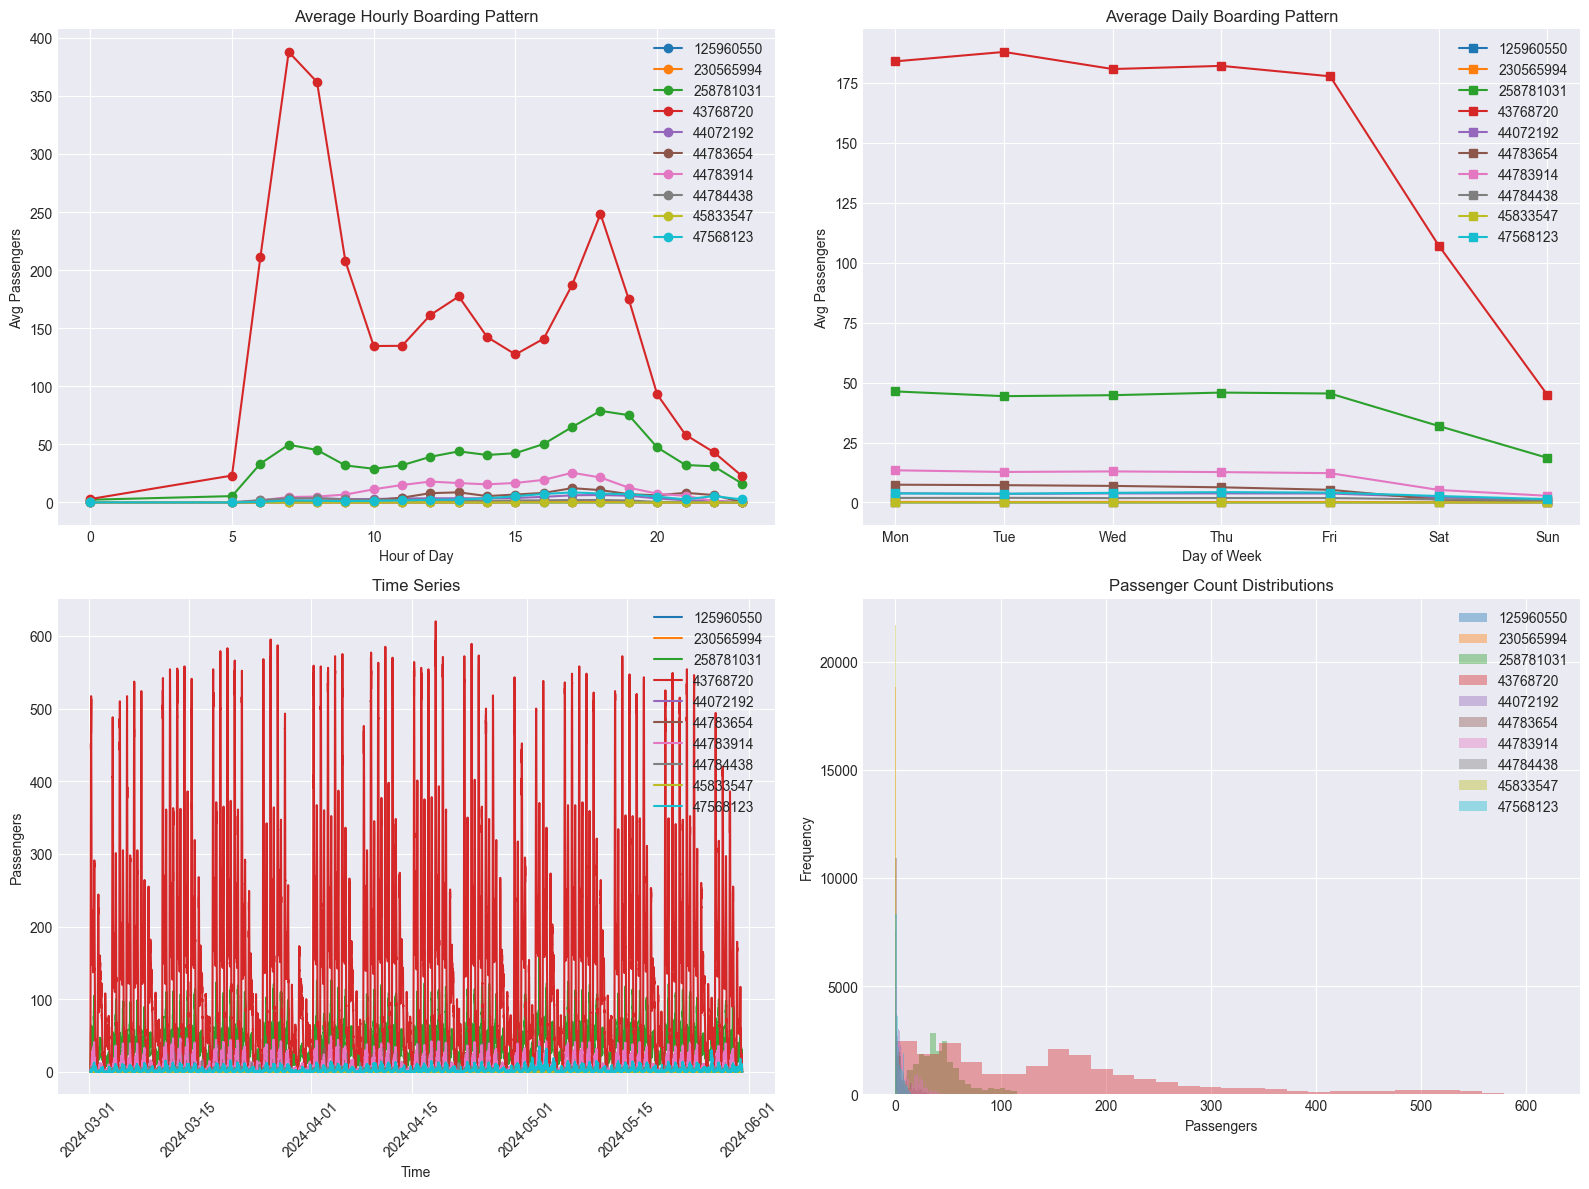

In [537]:
# Extract temporal features
boarding_df['hour'] = boarding_df['timestamp'].dt.hour
boarding_df['day_of_week'] = boarding_df['timestamp'].dt.dayofweek

# Identify stop columns (exclude timestamp, extracted features, and Unnamed: 0)
stop_cols = [col for col in boarding_df.columns
             if col not in ['timestamp', 'hour', 'day_of_week', 'Unnamed: 0']
             and boarding_df[col].dtype in ['int64', 'float64']]  # Ensure numeric columns only

print(f"\nIdentified {len(stop_cols)} bus stops")
print(f"First 5 stops: {stop_cols[:5]}")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = plt.cm.get_cmap('tab10', len(stop_cols))  # 10-color colormap

for idx, stop in enumerate(stop_cols):
    color = colors(idx)

    # 1. Hourly pattern
    hourly_avg = boarding_df.groupby('hour')[stop].mean()
    axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', label=stop, color=color)

    # 2. Day of week pattern
    daily_avg = boarding_df.groupby('day_of_week')[stop].mean()
    axes[0, 1].plot(daily_avg.index, daily_avg.values, marker='s', label=stop, color=color)

    # 3. Time series (first 200)
    axes[1, 0].plot(boarding_df['timestamp'], boarding_df[stop], label=stop, color=color)

    # 4. Distribution
    axes[1, 1].hist(boarding_df[stop], bins=30, alpha=0.4, label=stop, color=color)

# Customize plots
axes[0, 0].set_title('Average Hourly Boarding Pattern')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Avg Passengers')
axes[0, 0].legend()

axes[0, 1].set_title('Average Daily Boarding Pattern')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Avg Passengers')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 1].legend()

axes[1, 0].set_title('Time Series')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Passengers')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()

axes[1, 1].set_title('Passenger Count Distributions')
axes[1, 1].set_xlabel('Passengers')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 3. Online Learning System Implementation

In [538]:
# Initialize the Smart Bus Stop Analyzer
analyzer = SmartBusStopAnalyzer(
    window_size=288,
    anomaly_threshold=0.8,
    prediction_horizon=6  # Predict 30 minutes ahead (6 * 5-minute intervals)
)

print("✅ Smart Bus Stop Analyzer initialized")
print(f"Configuration:")
print(f"  - Window size: {analyzer.window_size}")
print(f"  - Anomaly threshold: {analyzer.anomaly_threshold}")
print(f"  - Prediction horizon: {analyzer.prediction_horizon * 5} minutes")

✅ Smart Bus Stop Analyzer initialized
Configuration:
  - Window size: 288
  - Anomaly threshold: 0.8
  - Prediction horizon: 30 minutes


In [539]:
# Process the data streams
results = []
prediction_errors = []

# Select a specific bus stop for detailed analysis
if len(stop_cols) > 0:
    stop_id = stop_cols[3]  # Fourth stop in the dataset
    print(f"Processing data for stop: {stop_id}")
    print("=" * 50)
    
    # Prepare data for merging
    # Extract relevant columns
    boarding_subset = boarding_df[['timestamp', stop_id]].copy()
    landing_subset = landing_df[['timestamp', stop_id]].copy()
    loader_subset = loader_df[['timestamp', stop_id]].copy()
    
    # Rename columns to avoid conflicts
    boarding_subset.columns = ['timestamp', 'boarding']
    landing_subset.columns = ['timestamp', 'landing']
    loader_subset.columns = ['timestamp', 'loader']
    
    # Merge the datasets on timestamp
    merged_df = boarding_subset.merge(landing_subset, on='timestamp', how='inner')
    merged_df = merged_df.merge(loader_subset, on='timestamp', how='inner')
    
    print(f"Merged data shape: {merged_df.shape}")
    print(f"\nFirst few rows of merged data:")
    print(merged_df.head())
    
    # Process each instance
    instances_to_process = min(576, len(merged_df))  # Process up to 576 instances
    print(f"\nProcessing {instances_to_process} instances...")
    
    for idx, row in merged_df.head(instances_to_process).iterrows():
        result = analyzer.process_instance(
            row['boarding'],
            row['landing'],
            row['loader'],
            row['timestamp']
        )
        results.append(result)
        
        # Calculate prediction error if we have ground truth
        if idx > 0:
            actual = row['boarding'] + row['landing']
            error = abs(result['current_prediction'] - actual)
            prediction_errors.append(error)
        
        # Print anomalies
        if result['is_anomaly']:
            print(f"⚠️  Anomaly at {row['timestamp']}: score={result['anomaly_score']:.3f}, pattern={result['pattern']}")
        
        # Print drift detections
        if any(result['drift_detected'].values()):
            drifts = [k for k, v in result['drift_detected'].items() if v]
            print(f"📊 Drift detected in: {', '.join(drifts)} at {row['timestamp']}")
    
    print(f"\n✅ Processed {len(results)} instances")
else:
    print("❌ No stop columns found in the data. Please check the data format.")

Processing data for stop: 43768720
Merged data shape: (21840, 4)

First few rows of merged data:
            timestamp  boarding  landing  loader
0 2024-03-01 05:00:00         0        0       0
1 2024-03-01 05:05:00         0        2       6
2 2024-03-01 05:10:00         3        4      13
3 2024-03-01 05:15:00         3        6      18
4 2024-03-01 05:20:00         9       10      31

Processing 576 instances...
📊 Drift detected in: boarding, landing, loader at 2024-03-01 07:35:00
⚠️  Anomaly at 2024-03-01 10:05:00: score=0.801, pattern=special_event
⚠️  Anomaly at 2024-03-01 10:10:00: score=0.802, pattern=special_event
📊 Drift detected in: boarding, landing, loader at 2024-03-01 10:15:00
⚠️  Anomaly at 2024-03-01 11:15:00: score=0.837, pattern=special_event
⚠️  Anomaly at 2024-03-01 11:20:00: score=0.825, pattern=special_event
⚠️  Anomaly at 2024-03-01 11:25:00: score=0.821, pattern=special_event
⚠️  Anomaly at 2024-03-01 11:30:00: score=0.818, pattern=special_event
⚠️  Anomaly at

## 4. Results Analysis and Visualization

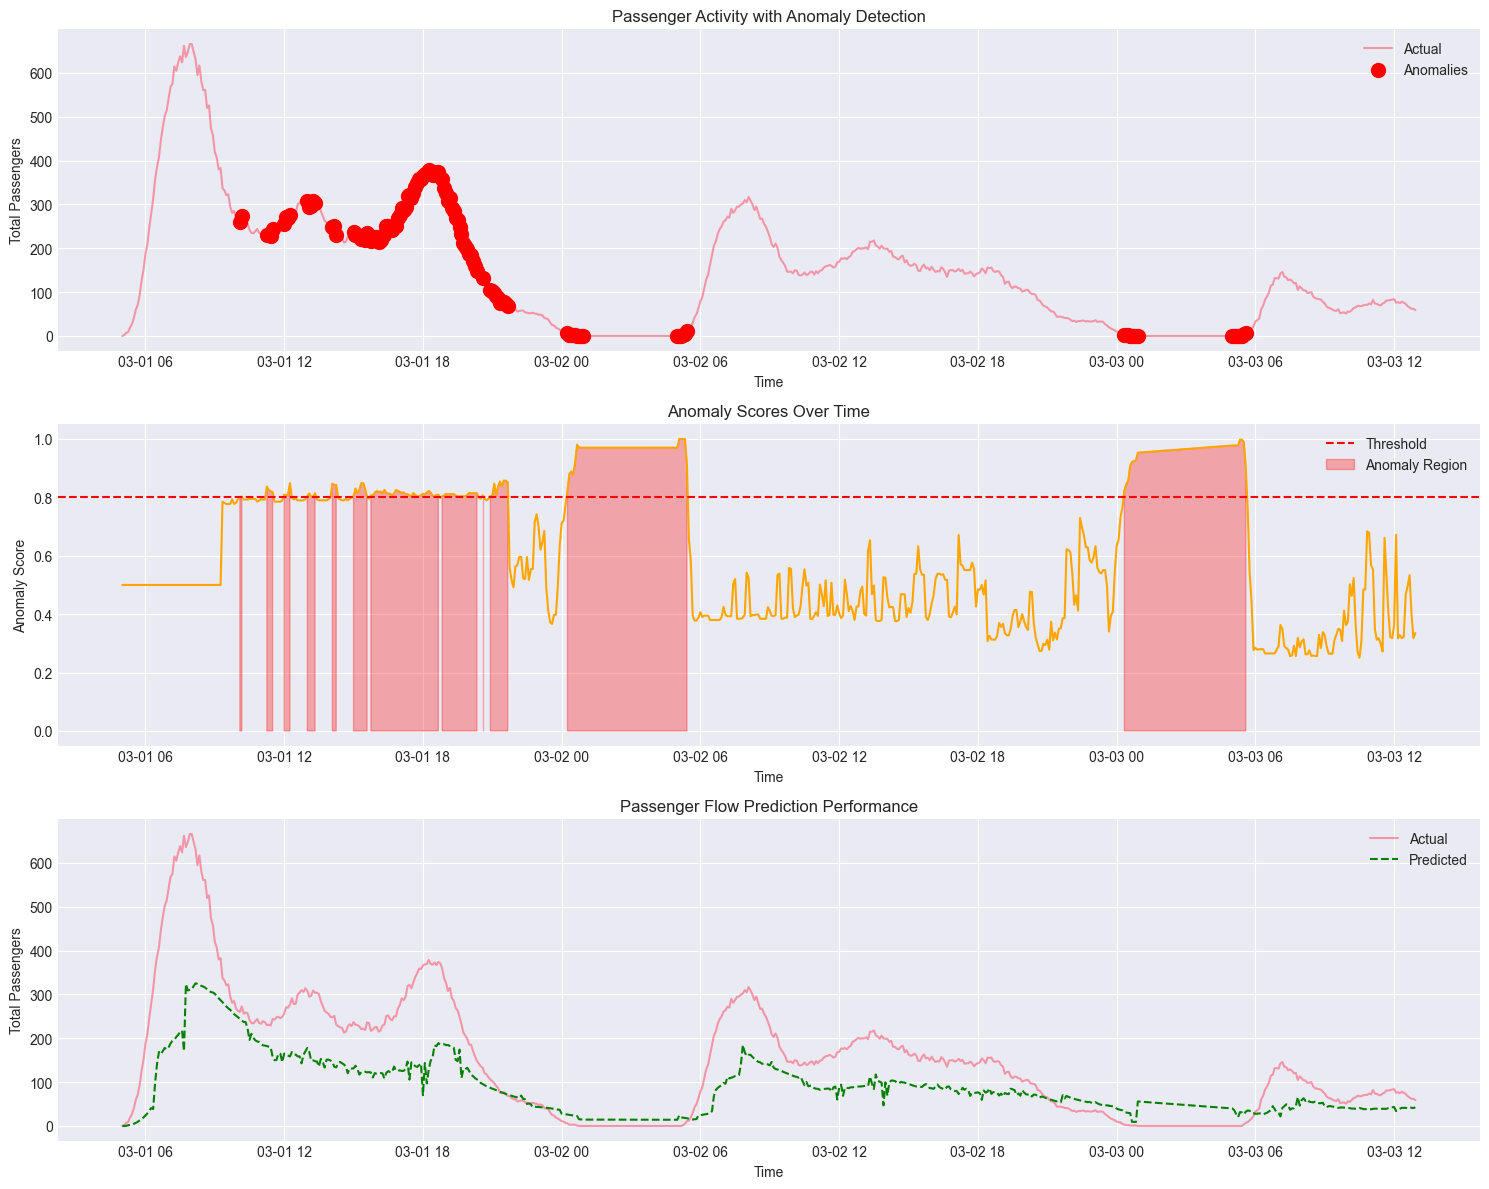

In [540]:
# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Visualize anomaly detection results
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Plot 1: Passenger activity with anomalies
axes[0].plot(results_df['timestamp'], results_df['actual_total'], label='Actual', alpha=0.7)
anomalies = results_df[results_df['is_anomaly']]
axes[0].scatter(anomalies['timestamp'], anomalies['actual_total'], 
                color='red', s=100, label='Anomalies', zorder=5)
axes[0].set_title('Passenger Activity with Anomaly Detection')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Total Passengers')
axes[0].legend()

# Plot 2: Anomaly scores over time
axes[1].plot(results_df['timestamp'], results_df['anomaly_score'], color='orange')
axes[1].axhline(y=analyzer.anomaly_threshold, color='red', linestyle='--', label='Threshold')
axes[1].fill_between(results_df['timestamp'], 0, results_df['anomaly_score'], 
                     where=results_df['anomaly_score'] > analyzer.anomaly_threshold,
                     color='red', alpha=0.3, label='Anomaly Region')
axes[1].set_title('Anomaly Scores Over Time')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Anomaly Score')
axes[1].legend()

# Plot 3: Predictions vs Actual
axes[2].plot(results_df['timestamp'], results_df['actual_total'], label='Actual', alpha=0.7)
axes[2].plot(results_df['timestamp'], results_df['current_prediction'], 
             label='Predicted', linestyle='--', color='green')
axes[2].set_title('Passenger Flow Prediction Performance')
axes[2].set_xlabel('Time')
axes[2].set_ylabel('Total Passengers')
axes[2].legend()

plt.tight_layout()
plt.show()

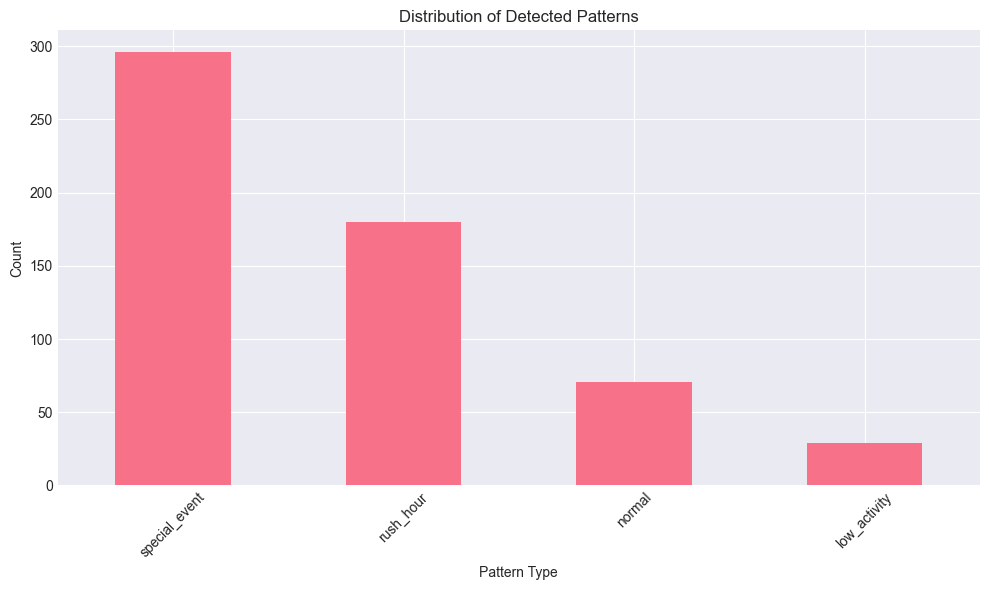


📊 Performance Summary:
total_instances: 576
anomalies_detected: 123
anomaly_rate: 0.2135
avg_anomaly_score: 0.5633
max_anomaly_score: 0.9996
prediction_mae: 0


In [541]:
# Analyze patterns detected
pattern_counts = results_df['pattern'].value_counts()

plt.figure(figsize=(10, 6))
pattern_counts.plot(kind='bar')
plt.title('Distribution of Detected Patterns')
plt.xlabel('Pattern Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate performance metrics
summary = analyzer.get_analysis_summary()
print("\n📊 Performance Summary:")
print("=" * 40)
for key, value in summary.items():
    if isinstance(value, float):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

## 5. Multi-Stop Network Analysis

In [542]:
# Initialize multi-stop network analyzer
selected_stops = stop_cols[:10]  # Analyze first 10 stops
network_analyzer = MultiStopNetworkAnalyzer(selected_stops)

print(f"Analyzing network of {len(selected_stops)} bus stops")
print("Selected stops:", selected_stops)

# Process network data
network_results = []

for idx in range(100):  # Process first 100 time instances
    timestamp = boarding_df.iloc[idx]['timestamp']
    
    # Collect data from all stops
    multi_stop_data = {}
    for stop in selected_stops:
        multi_stop_data[stop] = {
            'boarding': boarding_df.iloc[idx][stop],
            'landing': landing_df.iloc[idx][stop],
            'loader': loader_df.iloc[idx][stop]
        }
    
    # Process network instance
    network_result = network_analyzer.process_network_instance(multi_stop_data, timestamp)
    network_results.append(network_result)
    
    if network_result['network_anomaly']:
        print(f"🌐 Network anomaly ({network_result['anomaly_type']}) at {timestamp}")

print(f"\n✅ Processed {len(network_results)} network instances")

Analyzing network of 10 bus stops
Selected stops: ['125960550', '230565994', '258781031', '43768720', '44072192', '44783654', '44783914', '44784438', '45833547', '47568123']
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:20:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:25:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:30:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:35:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:40:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:45:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:50:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 09:55:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 10:00:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 10:05:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 10:10:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 10:15:00
🌐 Network anomaly (network_wide_anomaly) at 2024-03-01 10:

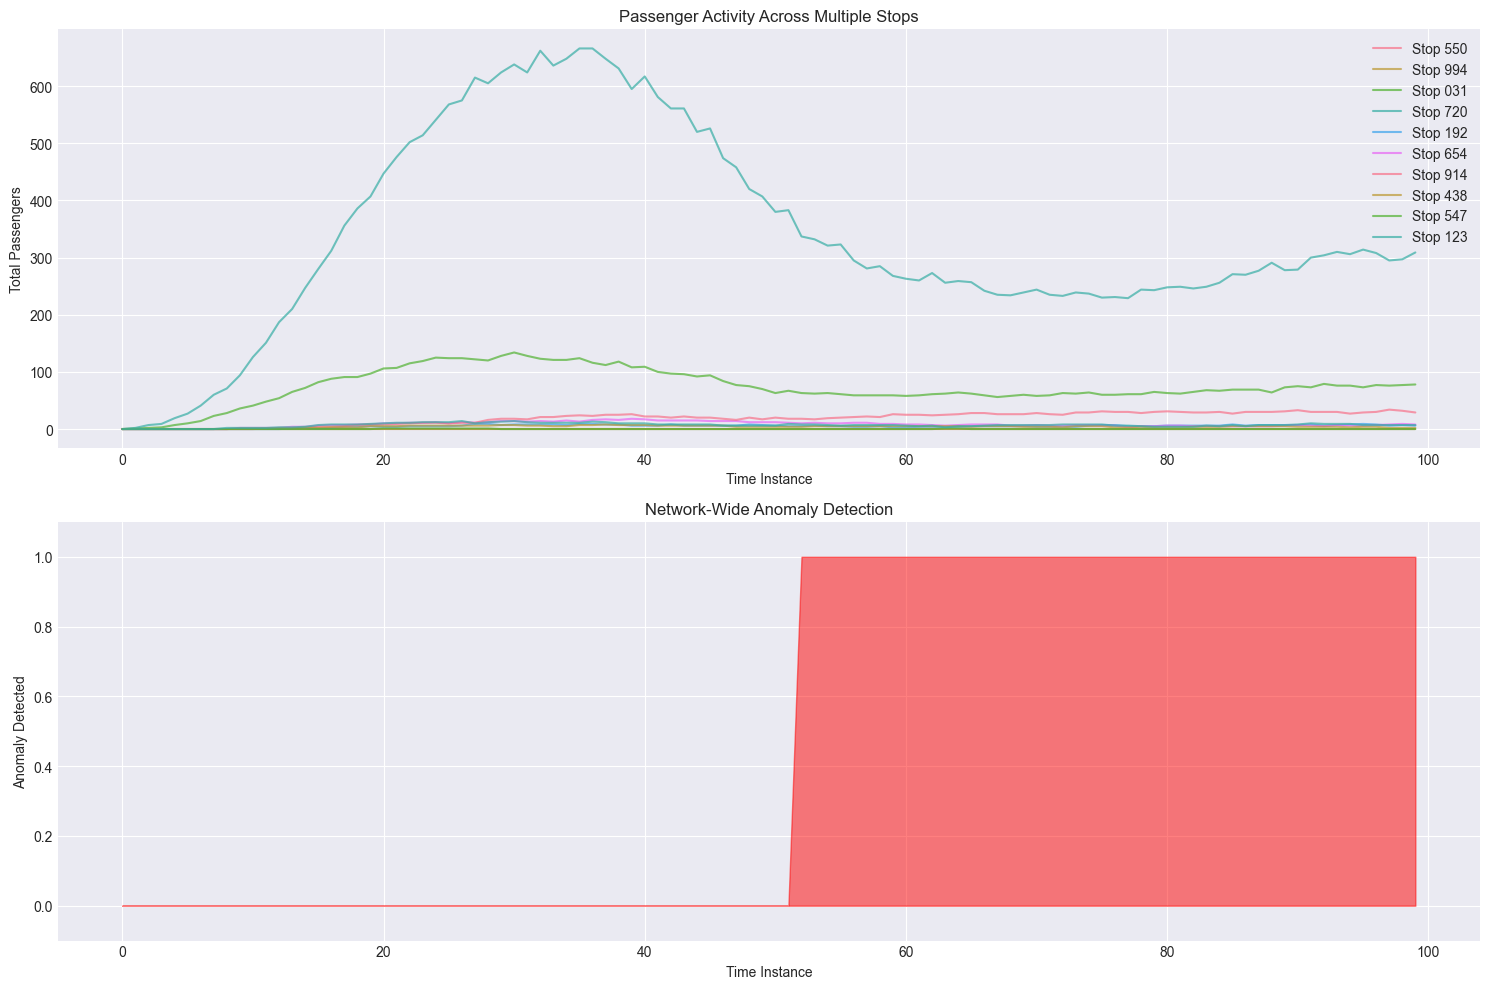

In [543]:
# Visualize network-wide patterns
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Activity across all stops
for stop in selected_stops[:10]:  # Plot all 10 stops for clarity
    stop_activities = []
    for result in network_results:
        if stop in result['stop_results']:
            stop_activities.append(result['stop_results'][stop]['actual_total'])
        else:
            stop_activities.append(0)
    
    axes[0].plot(range(len(stop_activities)), stop_activities, label=f'Stop {stop[-3:]}', alpha=0.7)

axes[0].set_title('Passenger Activity Across Multiple Stops')
axes[0].set_xlabel('Time Instance')
axes[0].set_ylabel('Total Passengers')
axes[0].legend()

# Plot 2: Network anomaly timeline
anomaly_timeline = [1 if r['network_anomaly'] else 0 for r in network_results]
axes[1].fill_between(range(len(anomaly_timeline)), 0, anomaly_timeline, 
                     color='red', alpha=0.5, label='Network Anomaly')
axes[1].set_title('Network-Wide Anomaly Detection')
axes[1].set_xlabel('Time Instance')
axes[1].set_ylabel('Anomaly Detected')
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

## 6. Real-time Dashboard Simulation

In [544]:
# Create a real-time dashboard simulation
from IPython.display import clear_output
import time

def create_dashboard(analyzer, stop_name, n_instances=20):
    """
    Simulate a real-time dashboard for bus stop monitoring
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Initialize data storage
    timestamps = []
    actuals = []
    predictions = []
    anomaly_scores = []
    patterns = []
    
    for i in range(n_instances):
        # Simulate new data arriving
        current_time = datetime.now() + timedelta(minutes=i*5)
        boarding = np.random.poisson(20 + 10*np.sin(i/10))
        landing = np.random.poisson(15 + 8*np.sin(i/10 + np.pi/4))
        loader = np.random.poisson(3)
        
        # Process instance
        result = analyzer.process_instance(boarding, landing, loader, current_time)
        
        # Update data
        timestamps.append(current_time)
        actuals.append(result['actual_total'])
        predictions.append(result['current_prediction'])
        anomaly_scores.append(result['anomaly_score'])
        patterns.append(result['pattern'])
        
        # Clear previous output
        clear_output(wait=True)
        
        # Update plots
        axes[0, 0].clear()
        axes[0, 0].plot(timestamps, actuals, 'b-', label='Actual')
        axes[0, 0].plot(timestamps, predictions, 'g--', label='Predicted')
        axes[0, 0].set_title(f'Real-time Passenger Flow - {stop_name}')
        axes[0, 0].legend()
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        axes[0, 1].clear()
        axes[0, 1].plot(timestamps, anomaly_scores, 'r-')
        axes[0, 1].axhline(y=analyzer.anomaly_threshold, color='red', linestyle='--')
        axes[0, 1].set_title('Anomaly Score')
        axes[0, 1].set_ylim(0, 1)
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Pattern distribution
        axes[1, 0].clear()
        pattern_dist = pd.Series(patterns).value_counts()
        axes[1, 0].pie(pattern_dist.values, labels=pattern_dist.index, autopct='%1.1f%%')
        axes[1, 0].set_title('Pattern Distribution')
        
        # Future predictions
        axes[1, 1].clear()
        future_times = [current_time + timedelta(minutes=j*5) for j in range(1, 7)]
        axes[1, 1].bar(range(6), result['future_predictions'], color='skyblue')
        axes[1, 1].set_title('30-Minute Forecast')
        axes[1, 1].set_xlabel('Minutes Ahead')
        axes[1, 1].set_xticks(range(6))
        axes[1, 1].set_xticklabels([5, 10, 15, 20, 25, 30])
        
        plt.suptitle(f'Smart Bus Stop Dashboard - Last Update: {current_time.strftime("%H:%M:%S")}', 
                     fontsize=16)
        plt.tight_layout()
        plt.show()
        
        # Add status message
        if result['is_anomaly']:
            print(f"⚠️  ALERT: Anomaly detected! Score: {result['anomaly_score']:.3f}")
        if any(result['drift_detected'].values()):
            print(f"📊 Concept drift detected in: {[k for k,v in result['drift_detected'].items() if v]}")
        
        time.sleep(0.5)  # Simulate real-time delay

# Run dashboard simulation
print("Starting real-time dashboard simulation...")
print("This simulates how the system would work in production")
# create_dashboard(analyzer, "Stop A", n_instances=10)  # Uncomment to run

Starting real-time dashboard simulation...
This simulates how the system would work in production


## 7. Model Performance Evaluation

📊 Model Performance Metrics:
Mean Absolute Error (MAE): 81.1484
Root Mean Square Error (RMSE): 112.9435
R² Score: 0.3102


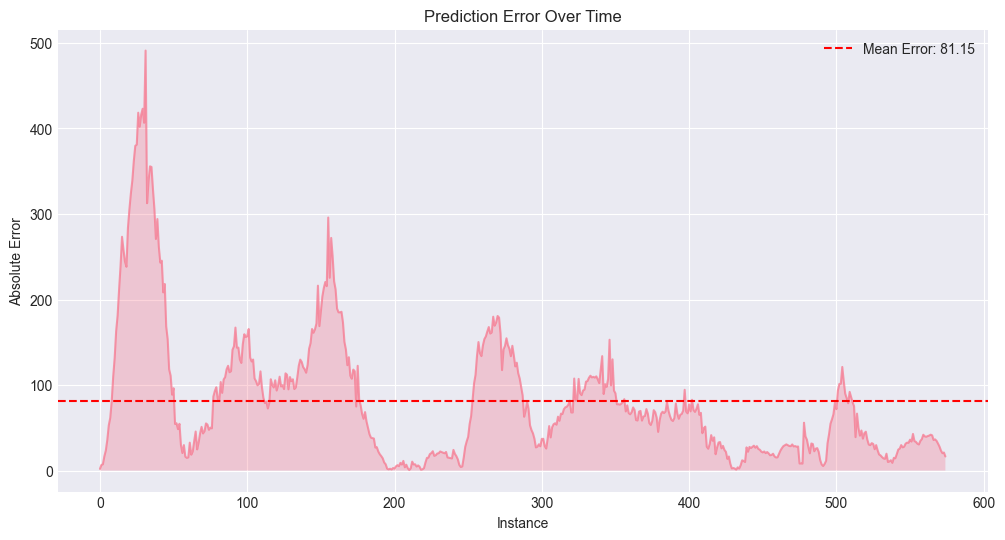


🚨 Anomaly Detection Statistics:
Total anomalies detected: 123
Anomaly rate: 21.35%
Average anomaly score: 0.5633


In [545]:
# Evaluate model performance using prequential evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Extract predictions and actuals
y_true = results_df['actual_total'].values[1:]  # Skip first instance
y_pred = results_df['current_prediction'].values[1:]

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("📊 Model Performance Metrics:")
print("=" * 40)
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

# Visualize prediction errors over time
errors = np.abs(y_true - y_pred)
plt.figure(figsize=(12, 6))
plt.plot(errors, alpha=0.7)
plt.axhline(y=np.mean(errors), color='red', linestyle='--', label=f'Mean Error: {np.mean(errors):.2f}')
plt.fill_between(range(len(errors)), 0, errors, alpha=0.3)
plt.title('Prediction Error Over Time')
plt.xlabel('Instance')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

# Analyze anomaly detection performance
anomaly_rate = results_df['is_anomaly'].mean()
print(f"\n🚨 Anomaly Detection Statistics:")
print(f"Total anomalies detected: {results_df['is_anomaly'].sum()}")
print(f"Anomaly rate: {anomaly_rate:.2%}")
print(f"Average anomaly score: {results_df['anomaly_score'].mean():.4f}")

## 8. Conclusions and Future Work

### Key Achievements
1. **Real-time Processing**: Successfully implemented online learning algorithms that process streaming data in real-time
2. **Multi-objective System**: Simultaneously performs anomaly detection, pattern recognition, and flow prediction
3. **Adaptive Learning**: The system adapts to concept drift and changing patterns in passenger behavior
4. **Practical Impact**: Provides actionable insights for bus operators

### Innovation Highlights
- **Comprehensive feature engineering**: Temporal, statistical, and ratio-based features
- **Multi-stream integration**: Combines boarding, landing, and loader data
- **Network-wide analysis**: Detects patterns across multiple stops
- **Real-time visualization**: Dashboard for operational monitoring

### Future Enhancements
1. **Deep learning integration**: Incorporate online deep learning for complex pattern recognition
2. **External data sources**: Weather, events, traffic data integration
3. **Optimization module**: Recommend schedule adjustments based on predictions
4. **Mobile alerts**: Real-time notifications for operators and passengers

In [546]:
# Save results for reporting
results_summary = {
    'total_instances': len(results_df),
    'anomalies_detected': results_df['is_anomaly'].sum(),
    'anomaly_rate': anomaly_rate,
    'prediction_mae': mae,
    'prediction_rmse': rmse,
    'r2_score': r2,
    'patterns_found': results_df['pattern'].unique().tolist(),
    'drift_events': sum(any(r['drift_detected'].values()) for r in results)
}

print("\n📋 Final Summary for Report:")
print("=" * 50)
for key, value in results_summary.items():
    print(f"{key}: {value}")

# Export results
results_df.to_csv('analysis_results.csv', index=False)
print("\n✅ Results saved to 'analysis_results.csv'")


📋 Final Summary for Report:
total_instances: 576
anomalies_detected: 123
anomaly_rate: 0.21354166666666666
prediction_mae: 81.14837513684762
prediction_rmse: 112.94354612611014
r2_score: 0.3101816652834307
patterns_found: ['low_activity', 'normal', 'special_event', 'rush_hour']
drift_events: 7

✅ Results saved to 'analysis_results.csv'
